In [31]:
# !pip install Pillow

In [32]:
# Import Packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
#Gather the NLKT
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\14027\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\14027\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [33]:
# Import the Dataset
reviews = pd.read_csv("C:/Users/14027/Documents/Graduate_Schoolish/DSC_680/Term Project 2/airfrance_tripadvisor_reviews.csv")
reviews.head()

,rating,title,text,publishedDate
0,1,WORST AIRLINE,I travel a lot - and I travel often. Last week...,2024-11-13
1,1,Terrible experience with Airfrance,"This review is regarding flight AF185, we book...",2024-11-13
2,1,Extremely Disappointing Experience with Air Fr...,I recently flew with Air France on flight #185...,2024-11-12
3,1,Horrible,Wow!!! What a horrible experience!! I've alway...,2024-11-11
4,1,The Worst Flight Experience I’ve Ever Had,I spent a fantastic 10-day vacation in Hong Ko...,2024-11-11


In [34]:
# Exploratory Data Analysis
## Null Values
reviews.isna().any()

rating           False
title            False
text             False
publishedDate    False
dtype: bool

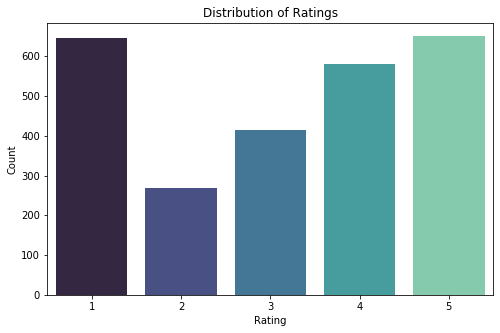

In [35]:
# Distribution of the ratings
plt.figure(figsize=(8, 5))
sns.countplot(x='rating', data=reviews, palette='mako')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

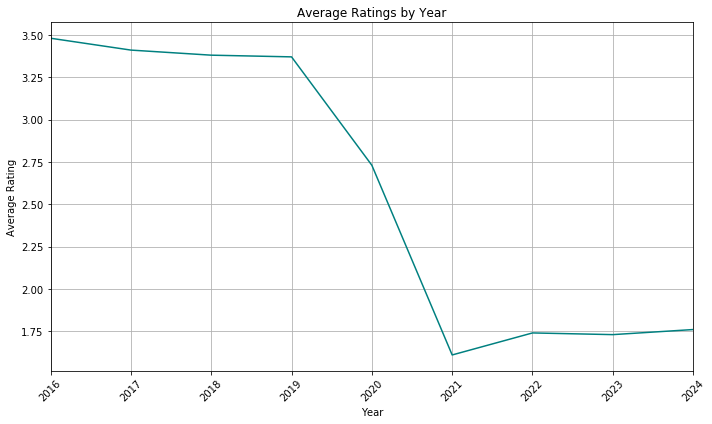

In [36]:
# # What times of the year are most popular: Months 
# Convert publishedDate to datetime
reviews['date'] = pd.to_datetime(reviews['publishedDate'], errors='coerce')

monthwise_ratings = reviews.groupby(reviews['date'].dt.to_period('Y'))['rating'].mean().round(2)
# monthwise_ratings

# Plotting the trend of ratings over time
plt.figure(figsize=(10, 6))
monthwise_ratings.plot(linestyle='-', color='teal', title='Average Ratings by Year')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [37]:
# Data Reformating
#Stopwords
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
extra_words = {'air', 'france', 'airfrance', 'flight', 'airline', 'fly', 'seat'
              'service', 'time', 'plane', 'go','u', 'get', 'SEAT', 'would', 'us', 
              'one', 'paris', 'say', 'tell', 'airport', 'hour', 'take'}
all_stopwords = stop_words.union(extra_words)

#Getting rid of extra symbols and apply to the dataset

def clean_text(text):
    text = text.lower()  
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  
    text = re.sub(r'\W', ' ', text)  
    text = re.sub(r'\s+', ' ', text).strip()  
    words = text.split()
    words = [lemmatizer.lemmatize(word, pos='v') for word in words if word not in all_stopwords]
    return ' '.join(words)

reviews['clean_text'] = reviews['text'].apply(clean_text)
reviews['clean_title'] = reviews['title'].apply(clean_text)

reviews['com_clean_text'] = reviews['clean_title'] +reviews['clean_text']

#  Creating Sentiment label
def label_sentiment(rating):
    if rating >= 4:
        return "positive"
    elif rating == 3:
        return 'neutral'
    else:
        return 'negative'

reviews['sentiment'] = reviews['rating'].apply(label_sentiment)

In [38]:
# TF-IDF: Term Frequenct -Inverse Document Frequency

# Intitalize

vectorizer = TfidfVectorizer(max_features=5000)
# fit and transform

X = vectorizer.fit_transform(reviews['com_clean_text'])

# Encode sentiment labels
le = LabelEncoder()
y = le.fit_transform(reviews['sentiment'])

In [39]:
# Train the SEntiment
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Log REgression

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

#Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))


Accuracy: 0.76171875

Classification Report:
               precision    recall  f1-score   support

    negative       0.76      0.84      0.80       181
     neutral       0.40      0.08      0.13        79
    positive       0.78      0.92      0.85       252

    accuracy                           0.76       512
   macro avg       0.65      0.61      0.59       512
weighted avg       0.71      0.76      0.72       512



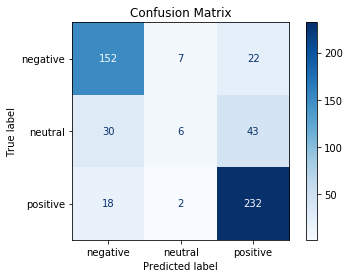

In [40]:
# Visual of the confusion matrix

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=le.classes_, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [41]:
# Rerun the model with class weighting
model = LogisticRegression(max_iter=1000, class_weight = 'balanced')
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

#Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))


Accuracy: 0.748046875

Classification Report:
               precision    recall  f1-score   support

    negative       0.81      0.80      0.80       181
     neutral       0.37      0.44      0.40        79
    positive       0.86      0.81      0.83       252

    accuracy                           0.75       512
   macro avg       0.68      0.68      0.68       512
weighted avg       0.76      0.75      0.75       512



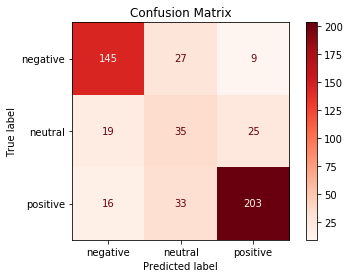

In [42]:
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=le.classes_, cmap='Reds')
plt.title("Confusion Matrix")
plt.show()

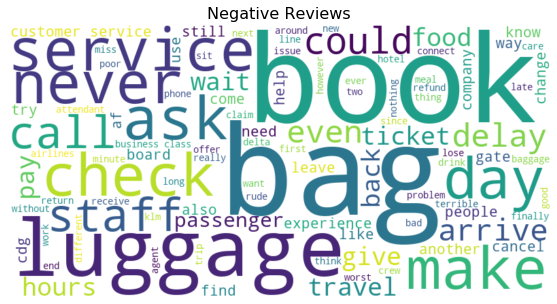

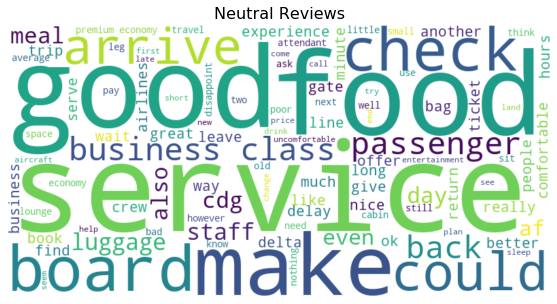

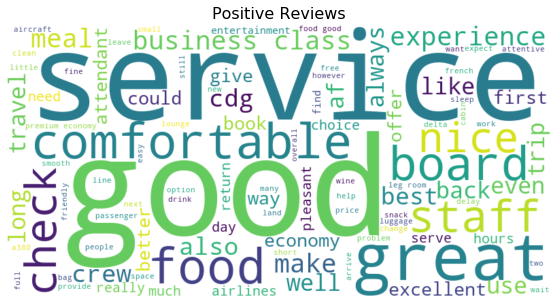

In [43]:
# Word Cloud for the different categories
# Stopping airline specific common works
# extra_words = {'air', 'france', 'airfrance', 'flight', 'airline', 'fly', 'seat'
#               'service', 'time', 'plane', 'go','u', 'get', 'SEAT', 'would', 'us', 
#               'one', 'paris', 'book'}
# all_stopwords = stop_words.union(extra_words)

# import wordcloud
from PIL import ImageDraw

# Monkey patch WordCloud to bypass textbbox issue
if not hasattr(ImageDraw.ImageDraw, "textbbox"):
    def textbbox(self, xy, text, font=None, anchor=None, *args, **kwargs):
        size = self.textsize(text, font=font)
        return (xy[0], xy[1], xy[0] + size[0], xy[1] + size[1])
    ImageDraw.ImageDraw.textbbox = textbbox


#  create work cloud function 
def plot_wordcloud(text, title):
    wordcloud = WordCloud(
    width=800, height=400, 
    background_color='white', 
    stopwords=all_stopwords, 
    colormap='viridis', 
    max_words=100). generate(' '.join(text))
    
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title,fontsize=16)
    plt.show()

# Word Clouds by sentiment
for sentiment in reviews['sentiment'].unique():
    subset = reviews[reviews['sentiment'] == sentiment]
    plot_wordcloud(subset['com_clean_text'], f'{sentiment.capitalize()} Reviews')